## 数据预处理

### 导入数据

In [1]:
import pandas as pd
from collections import Counter

df_train = pd.read_csv('data/tmp.csv') # 训练集
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76221 entries, 0 to 76220
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            76221 non-null  int64  
 1   id                    76221 non-null  int64  
 2   Gender                76221 non-null  object 
 3   Age                   76221 non-null  int64  
 4   Driving_License       76221 non-null  float64
 5   Region_Code           76221 non-null  float64
 6   Previously_Insured    76221 non-null  int64  
 7   Vehicle_Age           76221 non-null  object 
 8   Vehicle_Damage        76221 non-null  object 
 9   Annual_Premium        76221 non-null  float64
 10  Policy_Sales_Channel  76221 non-null  float64
 11  Vintage               76221 non-null  int64  
 12  Response              76221 non-null  int64  
 13  way                   76221 non-null  object 
dtypes: float64(4), int64(6), object(4)
memory usage: 8.1+ MB


### 数据格式处理（未升维）

In [2]:
# 数据格式处理
num_feat = ['Age', 'Vintage', 'Annual_Premium'] # 数值属性
nor_feat = ['Gender', 'Driving_License', 'Region_Code', 'Vehicle_Damage',  'Vehicle_Age', 'Policy_Sales_Channel', 'Previously_Insured'] # 标称属性

df_train['Gender'] = df_train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

### 缺失值处理
写了三种方法，自行选择
* 删除含有空值的行
* 逻辑回归填充`Driving_License` + 轮盘法填充 `Policy_Sales_Channel`
* 全部轮盘法填充

#### 1、删除含有空值的行

In [ ]:
# 缺失值检测处理：删除含有空值的行（标称属性）
df_train.dropna(axis=0, how='any', inplace=True)


#### 2、逻辑回归
*自行修改轮盘法`null_pro`*

In [ ]:
# 缺失值检测处理：逻辑回归（标称属性）

# 划分缺失值行

list_null = []
list_notnull = []

null_pro = ['Driving_License']
for pro in null_pro:                        
    for index in range(len(df_train[pro])):
        if pd.isnull(df_train[pro][index]):
            list_null.append(df_train[index:index+1])
        else:
            list_notnull.append(df_train[index:index+1])
df_null = pd.concat(list_null)
df_notnull = pd.concat(list_notnull)


In [ ]:
# 划分data、label
train_dl = df_notnull["Driving_License"]
train_data = df_notnull.drop(['Response', 'id', 'Driving_License', 'Policy_Sales_Channel'], axis = 1)

test_data = df_null.drop(['Response', 'id', 'Driving_License', 'Policy_Sales_Channel'], axis = 1)

In [ ]:
# 调用逻辑回归
from sklearn import linear_model
lr = linear_model.LogisticRegression()
lr.fit(train_data, train_dl)
predict_dl = lr.predict(test_data)

index_pdl = 0
for pro in null_pro:                        
    for index in range(len(df_train[pro])):
        if pd.isnull(df_train[pro][index]):
            df_train[pro][index] = predict_dl[index_pdl]
            index_pdl += 1

df_train.info()

#### 3、轮盘法

In [3]:
# 缺失值检测处理：轮盘法按概率填充（标称属性）
import random

null_pro = ['Driving_License', 'Policy_Sales_Channel']
for pro in null_pro:
    countPro = Counter([x for x in df_train[pro] if pd.isnull(x) == False])
    sumPro = sum(countPro.values())
    for index in range(len(df_train[pro])):
        if pd.isnull(df_train[pro][index]):
            needle = random.random() 
            needle *= sumPro
            for cur in countPro.most_common():
                needle -= cur[1]
                if needle <= 0:
                    df_train[pro][index] = cur[0]
                    break
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76221 entries, 0 to 76220
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            76221 non-null  int64  
 1   id                    76221 non-null  int64  
 2   Gender                76221 non-null  int64  
 3   Age                   76221 non-null  int64  
 4   Driving_License       76221 non-null  float64
 5   Region_Code           76221 non-null  float64
 6   Previously_Insured    76221 non-null  int64  
 7   Vehicle_Age           76221 non-null  object 
 8   Vehicle_Damage        76221 non-null  object 
 9   Annual_Premium        76221 non-null  float64
 10  Policy_Sales_Channel  76221 non-null  float64
 11  Vintage               76221 non-null  int64  
 12  Response              76221 non-null  int64  
 13  way                   76221 non-null  object 
dtypes: float64(4), int64(7), object(3)
memory usage: 8.1+ MB


## 对PSC进行处理

In [4]:
import numpy as np

In [5]:
psc_min = np.int(np.min(df_train['Policy_Sales_Channel']))
psc_max = np.int(np.max(df_train['Policy_Sales_Channel']))
psc_counts = [ np.sum(df_train['Policy_Sales_Channel'] == i) for i in range(psc_min, psc_max+1)]

In [6]:
psc_sort = psc_counts.copy()
psc_sort.sort(reverse=True)

In [7]:
psc_threshold = psc_sort[7]
psc_threshold

1210

In [8]:
df_train['Policy_Sales_Channel'] = df_train['Policy_Sales_Channel'].astype('int')

In [9]:
psc_sort[:8]

[26989, 15901, 14820, 4425, 2144, 1943, 1297, 1210]

In [12]:
psc_cats = 8
train_psc = df_train['Policy_Sales_Channel'].copy()
for i in range(len(train_psc)):
    now_psc = train_psc[i]-1
    if (psc_counts[now_psc] >= psc_threshold):
        for j in range(psc_cats):
            if (psc_sort[j] == psc_counts[now_psc]):
                train_psc[i] = j+1
                break
    else:
        train_psc[i] = 0
train_psc

0        3
1        1
2        3
3        6
4        1
        ..
76216    2
76217    0
76218    1
76219    3
76220    2
Name: Policy_Sales_Channel, Length: 76221, dtype: int64

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

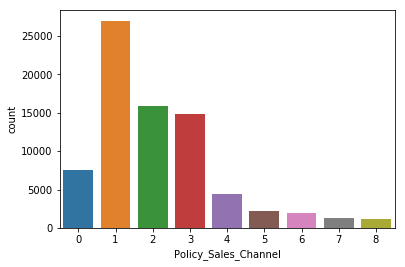

In [14]:
sns.countplot(train_psc)

In [15]:
df_train['Policy_Sales_Channel'] = train_psc
df_train

,Unnamed: 0,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,way
0,0,0,1,41,1.0,6.0,0,1-2 Year,Yes,36438.0,3,119,0,raw
1,1,1,0,28,1.0,28.0,1,< 1 Year,No,44632.0,1,91,0,raw
2,2,2,0,32,1.0,8.0,0,1-2 Year,Yes,36838.0,3,83,0,raw
3,3,3,1,36,1.0,28.0,1,1-2 Year,No,30074.0,6,273,0,raw
4,4,4,0,32,1.0,15.0,0,< 1 Year,Yes,38230.0,1,297,0,raw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,76216,76216,0,46,1.0,3.0,0,> 2 Years,Yes,30714.0,2,148,0,raw
76217,76217,76217,0,37,1.0,0.0,0,1-2 Year,No,2630.0,0,143,0,raw
76218,76218,76218,1,33,1.0,49.0,1,< 1 Year,No,33553.0,1,267,0,raw
76219,76219,76219,1,72,1.0,28.0,0,> 2 Years,Yes,34283.0,3,284,0,raw


## 同样Region_Code进行处理


In [16]:
rc_min = np.int(np.min(df_train['Region_Code']))
rc_max = np.int(np.max(df_train['Region_Code']))
rc_counts = [ np.sum(df_train['Region_Code'] == i) for i in range(rc_min, rc_max+1)]
psc_sort = psc_counts.copy()
psc_sort.sort(reverse=True)
psc_threshold = psc_sort[7]
psc_threshold

1210

In [17]:
df_train

,Unnamed: 0,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,way
0,0,0,1,41,1.0,6.0,0,1-2 Year,Yes,36438.0,3,119,0,raw
1,1,1,0,28,1.0,28.0,1,< 1 Year,No,44632.0,1,91,0,raw
2,2,2,0,32,1.0,8.0,0,1-2 Year,Yes,36838.0,3,83,0,raw
3,3,3,1,36,1.0,28.0,1,1-2 Year,No,30074.0,6,273,0,raw
4,4,4,0,32,1.0,15.0,0,< 1 Year,Yes,38230.0,1,297,0,raw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,76216,76216,0,46,1.0,3.0,0,> 2 Years,Yes,30714.0,2,148,0,raw
76217,76217,76217,0,37,1.0,0.0,0,1-2 Year,No,2630.0,0,143,0,raw
76218,76218,76218,1,33,1.0,49.0,1,< 1 Year,No,33553.0,1,267,0,raw
76219,76219,76219,1,72,1.0,28.0,0,> 2 Years,Yes,34283.0,3,284,0,raw


In [18]:
df_train['Policy_Sales_Channel'] = df_train['Policy_Sales_Channel'].astype('str')

In [19]:
df_train=pd.get_dummies(df_train,drop_first=True)
df_train

,Unnamed: 0,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Vintage,Response,...,Vehicle_Damage_Yes,Policy_Sales_Channel_1,Policy_Sales_Channel_2,Policy_Sales_Channel_3,Policy_Sales_Channel_4,Policy_Sales_Channel_5,Policy_Sales_Channel_6,Policy_Sales_Channel_7,Policy_Sales_Channel_8,way_test
0,0,0,1,41,1.0,6.0,0,36438.0,119,0,...,1,0,0,1,0,0,0,0,0,0
1,1,1,0,28,1.0,28.0,1,44632.0,91,0,...,0,1,0,0,0,0,0,0,0,0
2,2,2,0,32,1.0,8.0,0,36838.0,83,0,...,1,0,0,1,0,0,0,0,0,0
3,3,3,1,36,1.0,28.0,1,30074.0,273,0,...,0,0,0,0,0,0,1,0,0,0
4,4,4,0,32,1.0,15.0,0,38230.0,297,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,76216,76216,0,46,1.0,3.0,0,30714.0,148,0,...,1,0,1,0,0,0,0,0,0,0
76217,76217,76217,0,37,1.0,0.0,0,2630.0,143,0,...,0,0,0,0,0,0,0,0,0,0
76218,76218,76218,1,33,1.0,49.0,1,33553.0,267,0,...,0,1,0,0,0,0,0,0,0,0
76219,76219,76219,1,72,1.0,28.0,0,34283.0,284,0,...,1,0,0,1,0,0,0,0,0,0


In [20]:
df_train.drop(['id'], axis=1, inplace=True)
df_train=df_train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_1_Year_down", "Vehicle_Age_> 2 Years": "Vehicle_Age_2_Years_up"})
df_train

,Unnamed: 0,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Vintage,Response,Vehicle_Age_1_Year_down,...,Vehicle_Damage_Yes,Policy_Sales_Channel_1,Policy_Sales_Channel_2,Policy_Sales_Channel_3,Policy_Sales_Channel_4,Policy_Sales_Channel_5,Policy_Sales_Channel_6,Policy_Sales_Channel_7,Policy_Sales_Channel_8,way_test
0,0,1,41,1.0,6.0,0,36438.0,119,0,0,...,1,0,0,1,0,0,0,0,0,0
1,1,0,28,1.0,28.0,1,44632.0,91,0,1,...,0,1,0,0,0,0,0,0,0,0
2,2,0,32,1.0,8.0,0,36838.0,83,0,0,...,1,0,0,1,0,0,0,0,0,0
3,3,1,36,1.0,28.0,1,30074.0,273,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,32,1.0,15.0,0,38230.0,297,0,1,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,76216,0,46,1.0,3.0,0,30714.0,148,0,0,...,1,0,1,0,0,0,0,0,0,0
76217,76217,0,37,1.0,0.0,0,2630.0,143,0,0,...,0,0,0,0,0,0,0,0,0,0
76218,76218,1,33,1.0,49.0,1,33553.0,267,0,1,...,0,1,0,0,0,0,0,0,0,0
76219,76219,1,72,1.0,28.0,0,34283.0,284,0,0,...,1,0,0,1,0,0,0,0,0,0


### 后续数据处理

In [21]:
# 数据格式处理
df_train['Driving_License'] = df_train['Driving_License'].astype(int)
df_train['Region_Code'] = df_train['Region_Code'].astype(int)

In [22]:
df_train

,Unnamed: 0,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Vintage,Response,Vehicle_Age_1_Year_down,...,Vehicle_Damage_Yes,Policy_Sales_Channel_1,Policy_Sales_Channel_2,Policy_Sales_Channel_3,Policy_Sales_Channel_4,Policy_Sales_Channel_5,Policy_Sales_Channel_6,Policy_Sales_Channel_7,Policy_Sales_Channel_8,way_test
0,0,1,41,1,6,0,36438.0,119,0,0,...,1,0,0,1,0,0,0,0,0,0
1,1,0,28,1,28,1,44632.0,91,0,1,...,0,1,0,0,0,0,0,0,0,0
2,2,0,32,1,8,0,36838.0,83,0,0,...,1,0,0,1,0,0,0,0,0,0
3,3,1,36,1,28,1,30074.0,273,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,32,1,15,0,38230.0,297,0,1,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,76216,0,46,1,3,0,30714.0,148,0,0,...,1,0,1,0,0,0,0,0,0,0
76217,76217,0,37,1,0,0,2630.0,143,0,0,...,0,0,0,0,0,0,0,0,0,0
76218,76218,1,33,1,49,1,33553.0,267,0,1,...,0,1,0,0,0,0,0,0,0,0
76219,76219,1,72,1,28,0,34283.0,284,0,0,...,1,0,0,1,0,0,0,0,0,0


In [23]:
df_train.drop(['Unnamed: 0', 'way_test'], axis=1, inplace=True)

### 标准化
*处理数值属性`num_feat`*

In [24]:
# age_scaler = MinMaxScaler()
df_train['Age'] = (df_train['Age'] - min(df_train['Age']))/(max(df_train['Age']) - min(df_train['Age']))

# vintage_scaler = MinMaxScaler()
df_train['Vintage'] = (df_train['Vintage'] - min(df_train['Vintage']))/(max(df_train['Vintage']) - min(df_train['Vintage']))

# psc_scaler = StandardScaler() 
df_train['Annual_Premium'] = (df_train['Annual_Premium'] - np.mean(df_train['Annual_Premium'] )) / (np.std(df_train['Annual_Premium']))

In [25]:
df_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Vintage,Response,Vehicle_Age_1_Year_down,Vehicle_Age_2_Years_up,Vehicle_Damage_Yes,Policy_Sales_Channel_1,Policy_Sales_Channel_2,Policy_Sales_Channel_3,Policy_Sales_Channel_4,Policy_Sales_Channel_5,Policy_Sales_Channel_6,Policy_Sales_Channel_7,Policy_Sales_Channel_8
0,1,0.328125,1,6,0,0.336961,0.377163,0,0,0,1,0,0,1,0,0,0,0,0
1,0,0.125000,1,28,1,0.811089,0.280277,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0.187500,1,8,0,0.360106,0.252595,0,0,0,1,0,0,1,0,0,0,0,0
3,1,0.250000,1,28,1,-0.031278,0.910035,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0.187500,1,15,0,0.440651,0.993080,0,1,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,0,0.406250,1,3,0,0.005754,0.477509,0,0,1,1,0,1,0,0,0,0,0,0
76217,0,0.265625,1,0,0,-1.619267,0.460208,0,0,0,0,0,0,0,0,0,0,0,0
76218,1,0.203125,1,49,1,0.170026,0.889273,0,1,0,0,1,0,0,0,0,0,0,0
76219,1,0.812500,1,28,0,0.212266,0.948097,0,0,1,1,0,0,1,0,0,0,0,0


In [26]:
df_train.dtypes

Gender                       int64
Age                        float64
Driving_License              int64
Region_Code                  int64
Previously_Insured           int64
Annual_Premium             float64
Vintage                    float64
Response                     int64
Vehicle_Age_1_Year_down      uint8
Vehicle_Age_2_Years_up       uint8
Vehicle_Damage_Yes           uint8
Policy_Sales_Channel_1       uint8
Policy_Sales_Channel_2       uint8
Policy_Sales_Channel_3       uint8
Policy_Sales_Channel_4       uint8
Policy_Sales_Channel_5       uint8
Policy_Sales_Channel_6       uint8
Policy_Sales_Channel_7       uint8
Policy_Sales_Channel_8       uint8
dtype: object

In [44]:
df_train.dtypes

Gender                       int64
Age                        float64
Driving_License              int64
Region_Code                  int64
Previously_Insured           int64
Annual_Premium             float64
Vintage                    float64
Response                     int64
Vehicle_Age_1_Year_down      uint8
Vehicle_Age_2_Years_up       uint8
Vehicle_Damage_Yes           uint8
Policy_Sales_Channel_1       uint8
Policy_Sales_Channel_2       uint8
Policy_Sales_Channel_3       uint8
Policy_Sales_Channel_4       uint8
Policy_Sales_Channel_5       uint8
Policy_Sales_Channel_6       uint8
Policy_Sales_Channel_7       uint8
Policy_Sales_Channel_8       uint8
dtype: object

In [27]:
df_train.to_csv('data/tmp_clean_v1.csv', index=False)

In [49]:
!ls

data			 examples.desktop  rf_model.sav
Ensemble_learning.ipynb  nohup.out	   train_clean_v1.csv
